# Create Noiseless data for LCDM and f(R)

/n/home12/cgarciaquintero/testing/desilike/desilike/base.py:452: UserWarning: Parameter m_ncdm of <desilike.theories.primordial_cosmology.Cosmoprimo object at 0x14bc02047a30> is different from that of <desilike.theories.primordial_cosmology.Cosmoprimo object at 0x14bbc91c1b10>: {'value': (None, 0.059999919306783625)}.
  if self.mpicomm.rank == 0: warnings.warn(msg)
/n/home12/cgarciaquintero/testing/desilike/desilike/base.py:452: UserWarning: Parameter N_eff of <desilike.theories.primordial_cosmology.Cosmoprimo object at 0x14bc02047a30> is different from that of <desilike.theories.primordial_cosmology.Cosmoprimo object at 0x14bbc91c1b10>: {'value': (None, 3.045998221453431)}.
  if self.mpicomm.rank == 0: warnings.warn(msg)
/n/home12/cgarciaquintero/testing/desilike/desilike/base.py:452: UserWarning: Parameter w0_fld of <desilike.theories.primordial_cosmology.Cosmoprimo object at 0x14bc02047a30> is different from that of <desilike.theories.primordial_cosmology.Cosmoprimo object at 0x14bb

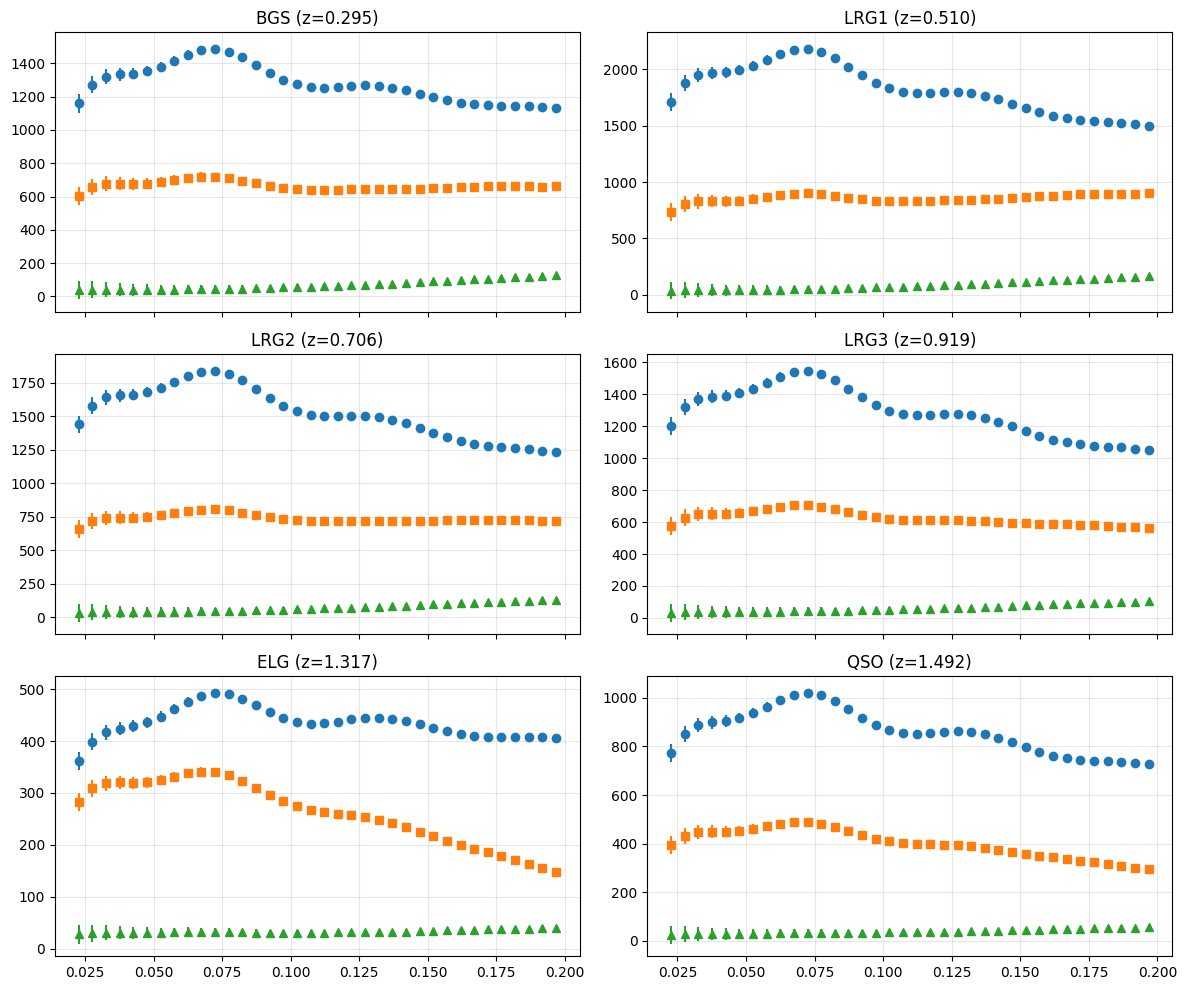

✔ Synthetic multipoles and covariances generated.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import pyfkpt.rsd as pyfkpt
from thecov import geometry, covariance

from desilike import parameter
from desilike.theories import Cosmoprimo
from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate
from desilike.base import BaseCalculator
from cosmoprimo.fiducial import DESI

# ======================================================
# 1. Setup
# ======================================================
model_choice = "LCDM"
output_dir = "/n/home12/cgarciaquintero/DESI/MG_validation/fR_noiseless"
os.makedirs(output_dir, exist_ok=True)

fR0 = 1e-4 if model_choice == "F4" else 1e-15

# ======================================================
# 2. Cosmology (MATCH DESILIKE)
# ======================================================
h      = 0.6736
ombh2  = 0.02237
omch2  = 0.12
omnuh2 = 0.06 / 93.14
Om     = (ombh2 + omch2 + omnuh2) / h**2

As   = 2.083e-09
ns   = 0.9649
Neff = 3.046

Omfid = 0.31519172481908053

# ======================================================
# 3. EFT + stochastic parameters
# ======================================================
alpha0, alpha2, alpha4 = 3.0, -1.0, 0.0
ctilde = 0.0
alpha0shot, alpha2shot = 0.08, -2.0
pshotp = 10000

# ======================================================
# 4. Tracer settings (unchanged)
# ======================================================
tracer_settings = {
    'BGS':  {'z_pk': 0.295, 'b1': 1.5, 'b2': -0.5247206065},
    'LRG1': {'z_pk': 0.51,  'b1': 2.1, 'b2': -0.9955559762},
    'LRG2': {'z_pk': 0.706, 'b1': 2.1, 'b2': -1.129586780},
    'LRG3': {'z_pk': 0.919, 'b1': 2.1, 'b2': -1.073936223},
    'ELG':  {'z_pk': 1.317, 'b1': 1.2, 'b2': 0.03376361031},
    'QSO':  {'z_pk': 1.492, 'b1': 2.1, 'b2': -0.7104953308},
}

for t in tracer_settings.values():
    b1 = t['b1']
    t['bs2']  = -4./7. * (b1 - 1)
    t['b3nl'] = 32./315. * (b1 - 1)
    t['pshotp'] = pshotp
    t['volume'] = 2000**3
    t['nbar']   = 1e-3 if b1 < 1.3 else (5e-4 if b1 == 2.1 else 3e-4)

# ======================================================
# 5. Fixed k-grid (unchanged)
# ======================================================
k_fixed = np.array([
    0.02271, 0.02768277, 0.03265554, 0.03762831, 0.04260109,
    0.04757386, 0.05254663, 0.05751940, 0.06249217, 0.06746494,
    0.07243771, 0.07741049, 0.08238326, 0.08735603, 0.09232880,
    0.09730157, 0.1022743,  0.1072471,  0.1122199,  0.1171927,
    0.1221654,  0.1271382,  0.1321110,  0.1370837,  0.1420565,
    0.1470293,  0.1520021,  0.1569748,  0.1619476,  0.1669204,
    0.1718931,  0.1768659,  0.1818387,  0.1868115,  0.1917842,
    0.1967570
])

# ======================================================
# --- Linear P(k) using Cosmoprimo + DirectPowerSpectrumTemplate ---
#     This matches EXACTLY the desilike FKPT setup
# ======================================================
def get_plin_cosmoprimo(z):
    cosmo = Cosmoprimo(
        engine="isitgr",
        MG_parameterization="muSigma",
        N_eff=Neff,
        m_ncdm=[0.06],
    )
    cosmo.init.params.data.append(
        parameter.Parameter(basename='mu0', value=0.0, fixed=True)
    )

    cosmo.init.params["h"].update(value=h)
    cosmo.init.params["omega_b"].update(value=ombh2)
    cosmo.init.params["omega_cdm"].update(value=omch2)
    cosmo.init.params["logA"].update(value=np.log(1e10 * As))
    cosmo.init.params["n_s"].update(value=ns)

    template = DirectPowerSpectrumTemplate(z=z, fiducial=DESI(), cosmo=cosmo)

    class _Wrap(BaseCalculator):
        def calculate(self):
            return template()

    _Wrap()()
    return np.array(template.k), np.array(template.pk_dd)

# ======================================================
# 6. Loop over tracers
# ======================================================
fig, axs = plt.subplots(3, 2, figsize=(12, 10), sharex=True)
axs = axs.flatten()

for i, (tracer, vals) in enumerate(tracer_settings.items()):

    z   = vals['z_pk']
    b1  = vals['b1']
    b2  = vals['b2']
    bs2 = vals['bs2']
    b3nl = vals['b3nl']
    nbar = vals['nbar']
    volume = vals['volume']

    nuis = [
        b1, b2, bs2, b3nl,
        alpha0, alpha2, alpha4,
        ctilde, alpha0shot, alpha2shot, pshotp
    ]

    # --- 1) Linear P(k) exactly like desilike ---
    k_lin, pk_lin = get_plin_cosmoprimo(z)

    # --- 2) compute FKPT tables (DESILIKE-LIKE SETTINGS) ---
    params_fkpt = dict(
        z=z, Om=Om, h=h,
        b1=b1, b2=b2, bs2=bs2, b3nl=b3nl,
        alpha0=alpha0, alpha2=alpha2, alpha4=alpha4,
        ctilde=ctilde,
        PshotP=pshotp,
        alpha0shot=alpha0shot,
        alpha2shot=alpha2shot,
        model="HDKI",
        use_beyond_eds_kernels=True,
        mg_variant="mu_OmDE",
        rescale_PS=False,
        nquadSteps=300,
        kmin=float(max(1e-3, min(k_lin))),
        kmax=min(max(k_lin), 0.5),
        Nk=min(len(k_lin), 240),
        mu0=0,
        chatty=0
    )

    tables = pyfkpt.compute_tables(k=k_lin, pk=pk_lin, **params_fkpt)

    # --- 3) RSD multipoles at fixed k-grid ---
    _, P0, P2, P4 = pyfkpt.rsd_multipoles(
        k=k_fixed,
        nuis=nuis,
        z=z,
        Om=Om,
        ap=False,  
        tables=tables,
        Omfid=Omfid
    )

    # --- Save synthetic data ---
    np.savetxt(f"{output_dir}/{tracer}_{model_choice}_k.txt", k_fixed)
    np.savetxt(f"{output_dir}/{tracer}_{model_choice}_P0P2P4.txt",
               np.concatenate([P0, P2, P4]))

    # --- 4) Gaussian covariance ---
    dk = np.mean(np.diff(k_fixed))
    kmin = k_fixed[0] - dk/2
    kmax = k_fixed[-1] + dk/2

    geom = geometry.BoxGeometry(volume=volume, nbar=nbar)
    cov = covariance.GaussianCovariance(geom)
    cov.set_kbins(kmin=kmin, kmax=kmax, dk=dk)
    cov.set_galaxy_pk_multipole(P0, ell=0)
    cov.set_galaxy_pk_multipole(P2, ell=2)
    cov.set_galaxy_pk_multipole(P4, ell=4)
    cov.compute_covariance()

    np.savetxt(f"{output_dir}/{tracer}_{model_choice}_cov.txt", cov.cov)

    # --- 5) Plot ---
    ax = axs[i]
    err = np.sqrt(np.diag(cov.cov))[:len(k_fixed)]

    ax.errorbar(k_fixed, k_fixed*P0, yerr=k_fixed*err, fmt='o')
    ax.errorbar(k_fixed, k_fixed*P2, yerr=k_fixed*err, fmt='s')
    ax.errorbar(k_fixed, k_fixed*P4, yerr=k_fixed*err, fmt='^')

    ax.set_title(f"{tracer} (z={z:.3f})")
    ax.grid(alpha=0.3)

fig.tight_layout()
plt.show()

print("✔ Synthetic multipoles and covariances generated.") 

# create data using desilike+fkpt

For LCDM

=== BGS: z=0.295, b1=1.500, b2=-0.525 ===


/n/home12/cgarciaquintero/.conda/envs/cosmodesi/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


=== LRG1: z=0.510, b1=2.100, b2=-0.996 ===
=== LRG2: z=0.706, b1=2.100, b2=-1.130 ===
=== LRG3: z=0.919, b1=2.100, b2=-1.074 ===
=== ELG: z=1.317, b1=1.200, b2=0.034 ===
=== QSO: z=1.492, b1=2.100, b2=-0.710 ===


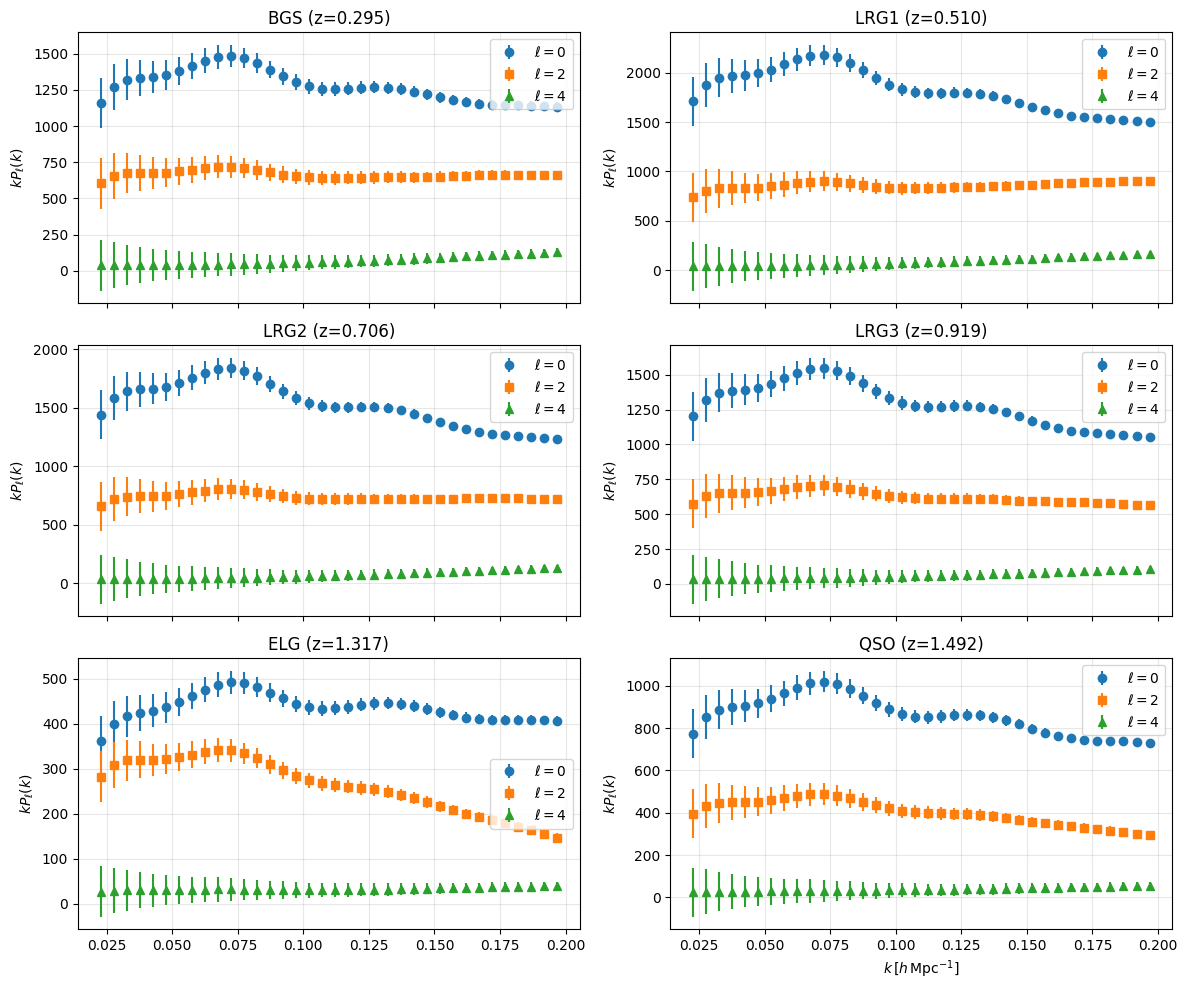

✔ Synthetic multipoles and covariances generated with desilike fkpt.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

from thecov import geometry, covariance

from desilike import parameter
from desilike.theories import Cosmoprimo
from desilike.theories.galaxy_clustering import (
    DirectPowerSpectrumTemplate,
    fkptTracerPowerSpectrumMultipoles,
)
from cosmoprimo.fiducial import DESI

# ======================================================
# 1. Setup
# ======================================================
model_choice = "LCDM"  # just used in filenames
output_dir = "/n/home12/cgarciaquintero/DESI/MG_validation/fR_noiseless_desilike"
os.makedirs(output_dir, exist_ok=True)

# ======================================================
# 2. Cosmology (MATCH DESILIKE)
# ======================================================
h      = 0.6736
ombh2  = 0.02237
omch2  = 0.12
omnuh2 = 0.06 / 93.14
Om     = (ombh2 + omch2 + omnuh2) / h**2

As   = 2.083e-09
ns   = 0.9649
Neff = 3.046

Omfid = 0.31519172481908053  # only kept for reference

# ======================================================
# 3. EFT + stochastic parameters
# ======================================================
alpha0, alpha2, alpha4 = 3.0, -1.0, 0.0
ctilde = 0.0
alpha0shot, alpha2shot = 0.08, -2.0
pshotp = 10000.0

# ======================================================
# 4. Tracer settings
# ======================================================
tracer_settings = {
    "BGS":  {"z_pk": 0.295, "b1": 1.5, "b2": -0.5247206065},
    "LRG1": {"z_pk": 0.51,  "b1": 2.1, "b2": -0.9955559762},
    "LRG2": {"z_pk": 0.706, "b1": 2.1, "b2": -1.129586780},
    "LRG3": {"z_pk": 0.919, "b1": 2.1, "b2": -1.073936223},
    "ELG":  {"z_pk": 1.317, "b1": 1.2, "b2": 0.03376361031},
    "QSO":  {"z_pk": 1.492, "b1": 2.1, "b2": -0.7104953308},
}

for t in tracer_settings.values():
    b1 = t["b1"]
    t["pshotp"] = pshotp
    t["volume"] = 2000.0**3
    # crude toy nbar choices
    t["nbar"]   = 1e-3 if b1 < 1.3 else (5e-4 if b1 == 2.1 else 3e-4)

# ======================================================
# 5. Fixed k-grid
# ======================================================
k_fixed = np.array([
    0.02271, 0.02768277, 0.03265554, 0.03762831, 0.04260109,
    0.04757386, 0.05254663, 0.05751940, 0.06249217, 0.06746494,
    0.07243771, 0.07741049, 0.08238326, 0.08735603, 0.09232880,
    0.09730157, 0.1022743,  0.1072471,  0.1122199,  0.1171927,
    0.1221654,  0.1271382,  0.1321110,  0.1370837,  0.1420565,
    0.1470293,  0.1520021,  0.1569748,  0.1619476,  0.1669204,
    0.1718931,  0.1768659,  0.1818387,  0.1868115,  0.1917842,
    0.1967570,
])

ells = (0, 2, 4)
MG_model   = "HDKI"
mg_variant = "mu_OmDE"
beyond_eds = True

# ======================================================
# 6. Helper: build cosmology (once per tracer)
# ======================================================
def build_cosmology():
    cosmo = Cosmoprimo(
        engine="isitgr",
        MG_parameterization="muSigma",
        N_eff=Neff,
        m_ncdm=[0.06],
    )

    # Fix tau and use σ8 as derived (matches your FS setup)
    if "tau_reio" in cosmo.init.params:
        cosmo.init.params["tau_reio"].update(fixed=True, value=0.0544)
    if "sigma8_m" in cosmo.init.params:
        cosmo.init.params["sigma8_m"] = {"derived": True, "latex": r"\sigma_8"}

    # Add mu0 with a flat prior but fix to GR for this synthetic run
    cosmo.init.params["mu0"] = dict(prior=dict(dist="uniform", limits=[-5.0, 5.0]))
    cosmo.init.params["mu0"].update(value=0.0, fixed=True)

    # Set baseline ΛCDM parameters
    cosmo_params = {
        "h": h,
        "omega_b": ombh2,
        "omega_cdm": omch2,
        "logA": np.log(1e10 * As),
        "n_s": ns,
    }
    for name, value in cosmo_params.items():
        if name in cosmo.init.params:
            cosmo.init.params[name].update(value=value)

    return cosmo

# ======================================================
# 7. Loop over tracers: compute Pℓ with desilike fkpt + covariances
# ======================================================
fig, axs = plt.subplots(3, 2, figsize=(12, 10), sharex=True)
axs = axs.flatten()

for i, (tracer, vals) in enumerate(tracer_settings.items()):

    z      = vals["z_pk"]
    b1     = vals["b1"]
    b2     = vals["b2"]
    bs2    = 0.0
    b3nl   = 0.0
    nbar   = vals["nbar"]
    volume = vals["volume"]

    print(f"=== {tracer}: z={z:.3f}, b1={b1:.3f}, b2={b2:.3f} ===")

    # Build cosmology and template
    cosmo = build_cosmology()
    template = DirectPowerSpectrumTemplate(z=z, fiducial=DESI(), cosmo=cosmo)

    # FKPT multipoles on k_fixed
    theory = fkptTracerPowerSpectrumMultipoles()
    theory.init.update(
        freedom="max",
        prior_basis="standard",
        tracer=tracer,
        template=template,
        k=k_fixed,
        ells=list(ells),
        model=MG_model,
        mg_variant=mg_variant,
        beyond_eds=beyond_eds,
        rescale_PS=False,
        shotnoise=pshotp,
    )

    # Fix nuisance parameters to the desired values
    fixed_vals = {
        "b1": b1,
        "b2": b2,
        "bs2": bs2,
        "b3nl": b3nl,
        "alpha0": alpha0,
        "alpha2": alpha2,
        "alpha4": alpha4,
        "ctilde": ctilde,
        "alpha0shot": alpha0shot,
        "alpha2shot": alpha2shot,
    }
    for name, val in fixed_vals.items():
        if name in theory.init.params:
            theory.init.params[name].update(fixed=True, value=val)

    # Evaluate theory
    P_theory = np.asarray(theory())

    # Decode P0, P2, P4 from theory output
    N = k_fixed.size
    if P_theory.ndim == 1:
        # Stacked [P0, P2, P4]
        P0 = P_theory[0 * N : 1 * N]
        P2 = P_theory[1 * N : 2 * N]
        P4 = P_theory[2 * N : 3 * N]
    elif P_theory.ndim == 2:
        # Shape (nells, Nk)
        # Assume order matches ells=(0,2,4)
        P0, P2, P4 = P_theory[0], P_theory[1], P_theory[2]
    else:
        raise RuntimeError(f"Unexpected theory output shape {P_theory.shape}")

    # --------------------------------------------------
    # Save synthetic data (k, P0P2P4)
    # --------------------------------------------------
    np.savetxt(f"{output_dir}/{tracer}_{model_choice}_k.txt", k_fixed)
    np.savetxt(
        f"{output_dir}/{tracer}_{model_choice}_P0P2P4.txt",
        np.concatenate([P0, P2, P4]),
    )

    # --------------------------------------------------
    # Gaussian covariance using thecov
    # --------------------------------------------------
    dk = np.mean(np.diff(k_fixed))
    kmin_bin = k_fixed[0] - dk / 2.0
    kmax_bin = k_fixed[-1] + dk / 2.0

    geom = geometry.BoxGeometry(volume=volume, nbar=nbar)
    cov = covariance.GaussianCovariance(geom)
    cov.set_kbins(kmin=kmin_bin, kmax=kmax_bin, dk=dk)
    cov.set_galaxy_pk_multipole(P0, ell=0)
    cov.set_galaxy_pk_multipole(P2, ell=2)
    cov.set_galaxy_pk_multipole(P4, ell=4)
    cov.compute_covariance()

    np.savetxt(f"{output_dir}/{tracer}_{model_choice}_cov.txt", cov.cov)

    safety_factor = 10.0
    cov_matrix = safety_factor * cov.cov
    np.savetxt(
        f"{output_dir}/{tracer}_{model_choice}_cov_rescaled.txt", cov_matrix
    )

    # --------------------------------------------------
    # Quick plot: k Pℓ(k) with toy error bars
    # (just using sqrt(diag) of rescaled covariance for the P0 block)
    # --------------------------------------------------
    ax = axs[i]
    err = np.sqrt(np.diag(cov_matrix))[: len(k_fixed)]

    ax.errorbar(k_fixed, k_fixed * P0, yerr=k_fixed * err, fmt="o", label=r"$\ell=0$")
    ax.errorbar(k_fixed, k_fixed * P2, yerr=k_fixed * err, fmt="s", label=r"$\ell=2$")
    ax.errorbar(k_fixed, k_fixed * P4, yerr=k_fixed * err, fmt="^", label=r"$\ell=4$")

    ax.set_title(f"{tracer} (z={z:.3f})")
    ax.set_ylabel(r"$k P_\ell(k)$")
    ax.grid(alpha=0.3)
    ax.legend()

axs[-1].set_xlabel(r"$k\,[h\,\mathrm{Mpc}^{-1}]$")
fig.tight_layout()
plt.show()

print("✔ Synthetic multipoles and covariances generated with desilike fkpt.")

For f(R)

=== BGS: z=0.295, b1=1.500, b2=-0.525 ===


/n/home12/cgarciaquintero/.conda/envs/cosmodesi/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


=== LRG1: z=0.510, b1=2.100, b2=-0.996 ===
=== LRG2: z=0.706, b1=2.100, b2=-1.130 ===
=== LRG3: z=0.919, b1=2.100, b2=-1.074 ===
=== ELG: z=1.317, b1=1.200, b2=0.034 ===
=== QSO: z=1.492, b1=2.100, b2=-0.710 ===


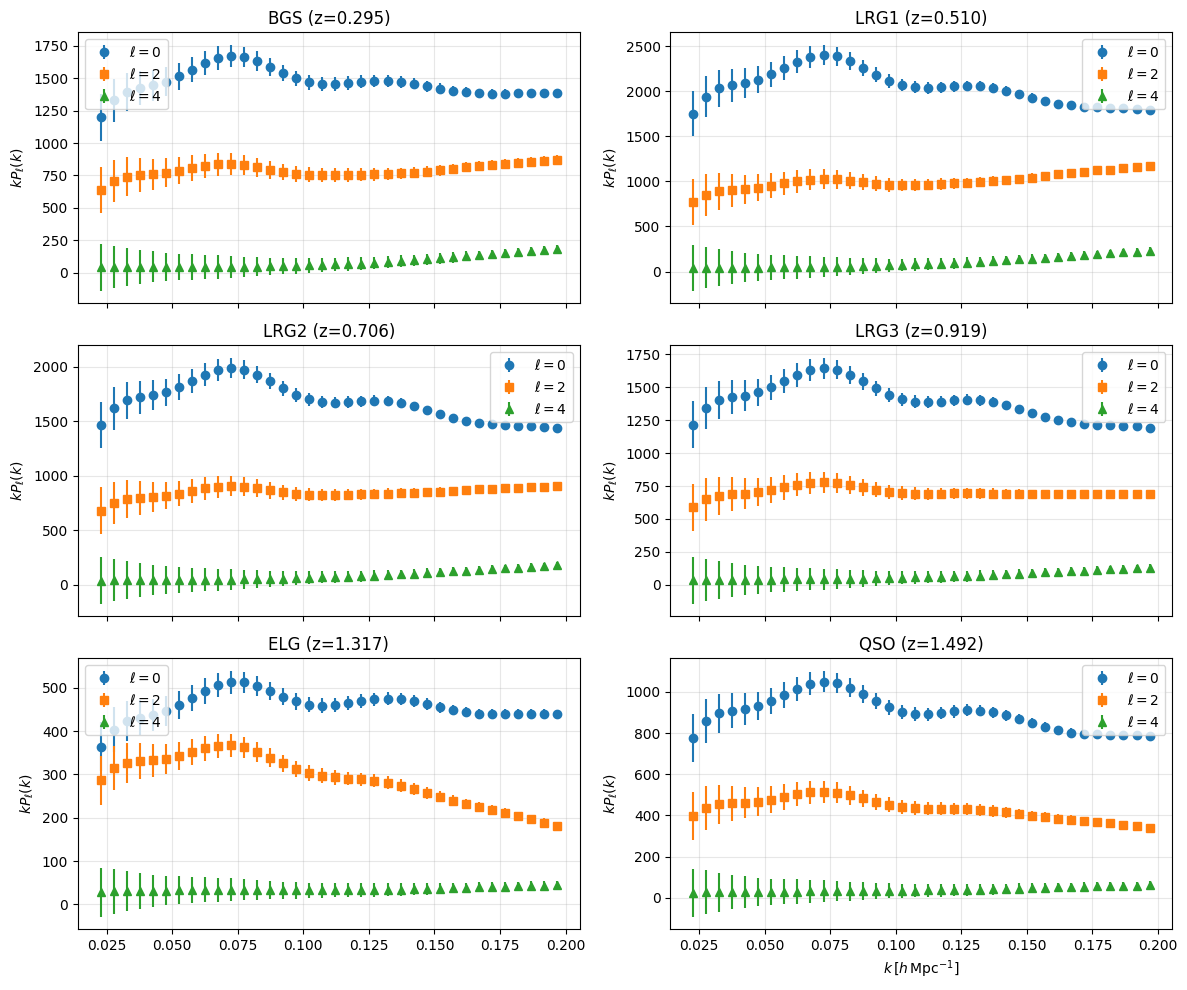

✔ Synthetic multipoles and covariances generated with desilike fkpt.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from thecov import geometry, covariance

from desilike import parameter
from desilike.theories import Cosmoprimo
from desilike.theories.galaxy_clustering import (
    DirectPowerSpectrumTemplate,
    fkptTracerPowerSpectrumMultipoles,
)
from cosmoprimo.fiducial import DESI

# ======================================================
# 1. Setup
# ======================================================
model_choice = "F4"  # just used in filenames
output_dir = "/n/home12/cgarciaquintero/DESI/MG_validation/fR_noiseless_desilike"
os.makedirs(output_dir, exist_ok=True)

# ======================================================
# 2. Cosmology (MATCH DESILIKE)
# ======================================================
h      = 0.6736
ombh2  = 0.02237
omch2  = 0.12
omnuh2 = 0.06 / 93.14
Om     = (ombh2 + omch2 + omnuh2) / h**2

As   = 2.083e-09
ns   = 0.9649
Neff = 3.046

Omfid = 0.31519172481908053  # only kept for reference

# ======================================================
# 3. EFT + stochastic parameters
# ======================================================
alpha0, alpha2, alpha4 = 3.0, -1.0, 0.0
ctilde = 0.0
alpha0shot, alpha2shot = 0.08, -2.0
pshotp = 10000.0

# ======================================================
# 4. Tracer settings
# ======================================================
tracer_settings = {
    "BGS":  {"z_pk": 0.295, "b1": 1.5, "b2": -0.5247206065},
    "LRG1": {"z_pk": 0.51,  "b1": 2.1, "b2": -0.9955559762},
    "LRG2": {"z_pk": 0.706, "b1": 2.1, "b2": -1.129586780},
    "LRG3": {"z_pk": 0.919, "b1": 2.1, "b2": -1.073936223},
    "ELG":  {"z_pk": 1.317, "b1": 1.2, "b2": 0.03376361031},
    "QSO":  {"z_pk": 1.492, "b1": 2.1, "b2": -0.7104953308},
}

for t in tracer_settings.values():
    b1 = t["b1"]
    t["pshotp"] = pshotp
    t["volume"] = 2000.0**3
    # crude toy nbar choices
    t["nbar"]   = 1e-3 if b1 < 1.3 else (5e-4 if b1 == 2.1 else 3e-4)

# ======================================================
# 5. Fixed k-grid
# ======================================================
k_fixed = np.array([
    0.02271, 0.02768277, 0.03265554, 0.03762831, 0.04260109,
    0.04757386, 0.05254663, 0.05751940, 0.06249217, 0.06746494,
    0.07243771, 0.07741049, 0.08238326, 0.08735603, 0.09232880,
    0.09730157, 0.1022743,  0.1072471,  0.1122199,  0.1171927,
    0.1221654,  0.1271382,  0.1321110,  0.1370837,  0.1420565,
    0.1470293,  0.1520021,  0.1569748,  0.1619476,  0.1669204,
    0.1718931,  0.1768659,  0.1818387,  0.1868115,  0.1917842,
    0.1967570,
])

ells = (0, 2, 4)
MG_model   = "HS"
mg_variant = "mu_OmDE"
beyond_eds = True

# ======================================================
# 6. Helper: build cosmology (once per tracer)
# ======================================================
def build_cosmology():
    cosmo = Cosmoprimo(
        engine="isitgr",
        MG_parameterization="muSigma",
        N_eff=Neff,
        m_ncdm=[0.06],
    )

    # Fix tau and use σ8 as derived (matches your FS setup)
    if "tau_reio" in cosmo.init.params:
        cosmo.init.params["tau_reio"].update(fixed=True, value=0.0544)
    if "sigma8_m" in cosmo.init.params:
        cosmo.init.params["sigma8_m"] = {"derived": True, "latex": r"\sigma_8"}

    # Add mu0 with a flat prior but fix to GR for this synthetic run
    cosmo.init.params["mu0"] = dict(prior=dict(dist="uniform", limits=[-5.0, 5.0]))
    cosmo.init.params["mu0"].update(value=0.0, fixed=True)

    # Set baseline ΛCDM parameters
    cosmo_params = {
        "h": h,
        "omega_b": ombh2,
        "omega_cdm": omch2,
        "logA": np.log(1e10 * As),
        "n_s": ns,
    }
    for name, value in cosmo_params.items():
        if name in cosmo.init.params:
            cosmo.init.params[name].update(value=value)

    return cosmo

# ======================================================
# 7. Loop over tracers: compute Pℓ with desilike fkpt + covariances
# ======================================================
fig, axs = plt.subplots(3, 2, figsize=(12, 10), sharex=True)
axs = axs.flatten()

for i, (tracer, vals) in enumerate(tracer_settings.items()):

    z      = vals["z_pk"]
    b1     = vals["b1"]
    b2     = vals["b2"]
    bs2    = 0.0
    b3nl   = 0.0
    nbar   = vals["nbar"]
    volume = vals["volume"]

    print(f"=== {tracer}: z={z:.3f}, b1={b1:.3f}, b2={b2:.3f} ===")

    # Build cosmology and template
    cosmo = build_cosmology()
    template = DirectPowerSpectrumTemplate(z=z, fiducial=DESI(), cosmo=cosmo)

    # FKPT multipoles on k_fixed
    theory = fkptTracerPowerSpectrumMultipoles()
    theory.init.update(
        freedom="max",
        prior_basis="standard",
        tracer=tracer,
        template=template,
        k=k_fixed,
        ells=list(ells),
        model=MG_model,
        beyond_eds=beyond_eds,
        rescale_PS=True,
        shotnoise=pshotp,
    )

    # Fix nuisance parameters to the desired values
    fixed_vals = {
        "b1": b1,
        "b2": b2,
        "bs2": bs2,
        "b3nl": b3nl,
        "alpha0": alpha0,
        "alpha2": alpha2,
        "alpha4": alpha4,
        "ctilde": ctilde,
        "alpha0shot": alpha0shot,
        "alpha2shot": alpha2shot,
    }
    for name, val in fixed_vals.items():
        if name in theory.init.params:
            theory.init.params[name].update(fixed=True, value=val)

    # Evaluate theory
    P_theory = np.asarray(theory())

    # Decode P0, P2, P4 from theory output
    N = k_fixed.size
    if P_theory.ndim == 1:
        # Stacked [P0, P2, P4]
        P0 = P_theory[0 * N : 1 * N]
        P2 = P_theory[1 * N : 2 * N]
        P4 = P_theory[2 * N : 3 * N]
    elif P_theory.ndim == 2:
        # Shape (nells, Nk)
        # Assume order matches ells=(0,2,4)
        P0, P2, P4 = P_theory[0], P_theory[1], P_theory[2]
    else:
        raise RuntimeError(f"Unexpected theory output shape {P_theory.shape}")

    # --------------------------------------------------
    # Save synthetic data (k, P0P2P4)
    # --------------------------------------------------
    np.savetxt(f"{output_dir}/{tracer}_{model_choice}_k.txt", k_fixed)
    np.savetxt(
        f"{output_dir}/{tracer}_{model_choice}_P0P2P4.txt",
        np.concatenate([P0, P2, P4]),
    )

    # --------------------------------------------------
    # Gaussian covariance using thecov
    # --------------------------------------------------
    dk = np.mean(np.diff(k_fixed))
    kmin_bin = k_fixed[0] - dk / 2.0
    kmax_bin = k_fixed[-1] + dk / 2.0

    geom = geometry.BoxGeometry(volume=volume, nbar=nbar)
    cov = covariance.GaussianCovariance(geom)
    cov.set_kbins(kmin=kmin_bin, kmax=kmax_bin, dk=dk)
    cov.set_galaxy_pk_multipole(P0, ell=0)
    cov.set_galaxy_pk_multipole(P2, ell=2)
    cov.set_galaxy_pk_multipole(P4, ell=4)
    cov.compute_covariance()

    np.savetxt(f"{output_dir}/{tracer}_{model_choice}_cov.txt", cov.cov)

    safety_factor = 10.0
    cov_matrix = safety_factor * cov.cov
    np.savetxt(
        f"{output_dir}/{tracer}_{model_choice}_cov_rescaled.txt", cov_matrix
    )

    # --------------------------------------------------
    # Quick plot: k Pℓ(k) with toy error bars
    # (just using sqrt(diag) of rescaled covariance for the P0 block)
    # --------------------------------------------------
    ax = axs[i]
    err = np.sqrt(np.diag(cov_matrix))[: len(k_fixed)]

    ax.errorbar(k_fixed, k_fixed * P0, yerr=k_fixed * err, fmt="o", label=r"$\ell=0$")
    ax.errorbar(k_fixed, k_fixed * P2, yerr=k_fixed * err, fmt="s", label=r"$\ell=2$")
    ax.errorbar(k_fixed, k_fixed * P4, yerr=k_fixed * err, fmt="^", label=r"$\ell=4$")

    ax.set_title(f"{tracer} (z={z:.3f})")
    ax.set_ylabel(r"$k P_\ell(k)$")
    ax.grid(alpha=0.3)
    ax.legend()

axs[-1].set_xlabel(r"$k\,[h\,\mathrm{Mpc}^{-1}]$")
fig.tight_layout()
plt.show()

print("✔ Synthetic multipoles and covariances generated with desilike fkpt.")

In [1]:
1e-4

0.0001

In [2]:
10**(-4)

0.0001